In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
!pip install scikit-multilearn==0.2.0

In [77]:
import tensorflow as tf

# Disable GPU (if available)
tf.config.set_visible_devices([], 'GPU')

# Or, you can specify the CPU device explicitly
# tf.config.set_visible_devices([], 'GPU:0')

# Now TensorFlow will use only the CPU

In [78]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.adapt import MLkNN
import sklearn.metrics as metrics
from sklearn.metrics import hamming_loss, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import multilabel_confusion_matrix
import os

In [79]:
os.chdir('/content/drive/MyDrive/NLP_Project/NLP/training')
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/content/drive/.shortcut-targets-by-id/1_CDY8Dm7L5Tja0e9ZZ13F9diyKUaPn_n/NLP_Project/NLP/training': ['train_en_l1.csv', 'train_en_l2.csv', 'train_en_l3.csv', 'train_hi_l1.csv', 'train_hi_l2.csv', 'train_hi_l3.csv', 'train_ta_l1.csv', 'train_ta_l2.csv', 'train_ta_l3.csv']


In [80]:
# d2 = pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_ta_l1.csv')
# d2 = d2.drop(['key', 'ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6'], axis=1)
# d2['Label'] = d2['Label'].astype(int)
# d2 = d2[['Label', 'text']]
# d2

In [81]:
# d2 = pd.read_csv('train_ta_l1_modded.csv')
d1 = pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_ta_l1.csv')
d2 = pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_ta_l2.csv')
d3 = pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_ta_l3.csv')

# Convert the relevant columns to numeric before applying max
for col in ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']:
    d1[col] = pd.to_numeric(d1[col], errors='coerce')  # errors='coerce' to handle non-numeric values
    d2[col] = pd.to_numeric(d2[col], errors='coerce')  # errors='coerce' to handle non-numeric values
    d3[col] = pd.to_numeric(d3[col], errors='coerce')  # errors='coerce' to handle non-numeric values

d1['label'] = d1[['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values

d1 = d1.drop(['key', 'ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6'], axis=1)
d1['label'] = d1['label'].astype(int)
d1 = d1[['label', 'text']]
d1

d2['label'] = d2[['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values

d2 = d2.drop(['key', 'ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6'], axis=1)
d2['label'] = d2['label'].astype(int)
d2 = d2[['label', 'text']]
d2

d3['label'] = d3[['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values

d3 = d3.drop(['key', 'ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6'], axis=1)
d3['label'] = d3['label'].astype(int)
d3 = d3[['label', 'text']]
d3


,label,text
0,0,*1. முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி...
1,1,சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக...
2,0,தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா
3,1,பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும் 😆
4,1,என்ன உடம்பு டா சாமி- சும்மா வளுவளுனு.. முலை ...
...,...,...
6774,1,😭😭😭 ஒம்மாள படிக்கல் புண்ட 😭😭😭
6775,0,🙄🙄🙄🙄 என்ன எழவுயா இது... இதெல்லாம் ஒரு பெருமை...
6776,0,🚨எக்ஸ் பிரஸ் பேர்ல் கப்பல் தீ விபத்துக்கு உள்ள...
6777,1,🤣 🤣 சல்லி ஜாதி வெறி முட்டா புண்ட உங்க பொண்ணுங்...


The label column is created in the original training dataset by taking the majority occurence of 0 or 1 among all the 6 annotators in columns - 'ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6'.

In [82]:
d1.rename(columns = {'Label':'label'}, inplace = True)
d1
d2.rename(columns = {'Label':'label'}, inplace = True)
d2
d3.rename(columns = {'Label':'label'}, inplace = True)
d3

,label,text
0,0,*1. முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி...
1,1,சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக...
2,0,தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா
3,1,பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும் 😆
4,1,என்ன உடம்பு டா சாமி- சும்மா வளுவளுனு.. முலை ...
...,...,...
6774,1,😭😭😭 ஒம்மாள படிக்கல் புண்ட 😭😭😭
6775,0,🙄🙄🙄🙄 என்ன எழவுயா இது... இதெல்லாம் ஒரு பெருமை...
6776,0,🚨எக்ஸ் பிரஸ் பேர்ல் கப்பல் தீ விபத்துக்கு உள்ள...
6777,1,🤣 🤣 சல்லி ஜாதி வெறி முட்டா புண்ட உங்க பொண்ணுங்...


In [83]:
df1=d1
df2=d3
df3=d3

df1
df2
df3

,label,text
0,0,*1. முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி...
1,1,சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக...
2,0,தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா
3,1,பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும் 😆
4,1,என்ன உடம்பு டா சாமி- சும்மா வளுவளுனு.. முலை ...
...,...,...
6774,1,😭😭😭 ஒம்மாள படிக்கல் புண்ட 😭😭😭
6775,0,🙄🙄🙄🙄 என்ன எழவுயா இது... இதெல்லாம் ஒரு பெருமை...
6776,0,🚨எக்ஸ் பிரஸ் பேர்ல் கப்பல் தீ விபத்துக்கு உள்ள...
6777,1,🤣 🤣 சல்லி ஜாதி வெறி முட்டா புண்ட உங்க பொண்ணுங்...


## Word Pre-Processing

In [84]:
## Word Pre-Processing ##
import nltk
import string
import re

## Function to normalize text for pre-processing ##
def normalize_text(text):
  emoji_pattern = re.compile("["
                              u"\U0001F600-\U0001F64F"  # emoticons
                              u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                              u"\U0001F680-\U0001F6FF"  # transport & map symbols
                              u"\U0001F700-\U0001F77F"  # alchemical symbols
                              u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                              u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                              u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                              u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                              u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                              u"\U00002702-\U000027B0"  # Dingbats
                              u"\U000024C2-\U0001F251"
                              "]+", flags=re.UNICODE)
  text = text.lower()
  text = re.sub('\[.*?\]', ' ', text)
  text = re.sub('https?://\S+|www\.\S+', ' ', text)
  text = re.sub('<.*?>+', ' ', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  text = re.sub('\n', ' ', text)
  text = re.sub('\w*\d\w*', ' ', text)
  text = re.sub('<handle replaced>', '', text)
  text = emoji_pattern.sub(r'', text)
  return text


In [85]:
## Apply the written function ##
df1['text'] = df1['text'].apply(lambda x: normalize_text(x))
df1
df2['text'] = df2['text'].apply(lambda x: normalize_text(x))
df2
df3['text'] = df3['text'].apply(lambda x: normalize_text(x))
df3

,label,text
0,0,முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி...
1,1,சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக...
2,0,தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா
3,1,பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும்
4,1,என்ன உடம்பு டா சாமி சும்மா வளுவளுனு முலை ...
...,...,...
6774,1,ஒம்மாள படிக்கல் புண்ட
6775,0,என்ன எழவுயா இது இதெல்லாம் ஒரு பெருமைனு ந...
6776,0,எக்ஸ் பிரஸ் பேர்ல் கப்பல் தீ விபத்துக்கு உள்ளா...
6777,1,சல்லி ஜாதி வெறி முட்டா புண்ட உங்க பொண்ணுங்க ...


# Train Test Splits

In [86]:
X1 = list(df1['text'])
#y = np.asarray(d1[d1.columns[1:]])
y_data1 = df1['label']
y1 = y_data1.values

X2 = list(df2['text'])
#y = np.asarray(d2[d2.columns[2:]])
y_data2 = df2['label']
y2 = y_data2.values

X3 = list(df3['text'])
#y = np.asarray(d3[d3.columns[3:]])
y_data3 = df3['label']
y3 = y_data3.values

In [87]:
len(X1)
len(X2)
len(X3)

6779

In [88]:
y1.size
y2.size
y2.size

6779

In [89]:
X1
X2
X3

['       முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி நிலம் இல்லை என்பதை நிரூபிக்க   ஆம் ஆண்டு வாங்கப்பட்ட பட்டாவை ஆதாரமாகக் காட்டியிருக்கிறார் மு க ஸ்டாலின்   இதற்கு காட்ட வேண்டிய     ',
 '   சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக்கு பேச்சு புண்டையை  பாரு     போய் சீனா காரனுக்கு சூத்து குடு போ',
 '   தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா',
 '   பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும் ',
 '  என்ன உடம்பு டா சாமி  சும்மா வளுவளுனு   முலை ஒவ்வொன்னும் தேங்காய் போல   நடிகை மாளவிகாவின் லேட்டஸ்ட் போட்டோஷூட்',
 '  கதற விட்ட புலம் பெயர் உறவுகள் கதி கலங்கி போன கோத்தா பையன்',
 '  பத்தினி வேச பு   வேற எடத்துல காட்டு இங்குட்டு ஒரு உருட்டு அங்குட்டு நல்லவன் வேசம் ஆ மூடிட்டு போடா மயிரு   \u200d',
 '  உன்னைய தூக்கி போட்டு நா ஓக்க   ',
 ' ஆடு திருடுனதுக்கு எப்பிடியும் தண்டனை கிடைச்சிரும்னு பயந்து ஆட்டைக்கூட ஒளிச்சி வச்சிட்டேன்          அப்புறம்         பக்கத்து தெருவுல கோழி திருடுனவனை ஏன் கைது செய்யலைன்னு சொல்லி ஜட்ஜய்யா என்னை விடுதலை செஞ்சிட்டாரு          ',
 ' ஊரடங்கால்   கோடிக்கு மேல் இழப்பு  

In [90]:
y1
y2
y3

array([0, 1, 0, ..., 0, 1, 1])

# Model CNN & Bi-LSTM

In [91]:
#Model CNN & Bi-LSTM
# Model CNN & Bi-LSTM
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dropout, Dense, Flatten, Bidirectional, GRU, concatenate, SpatialDropout1D
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Concatenate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
######## Textual Features for Embedding ###################
# max_len = 100
# max_features = 10000
# embed_size = 300
# tokenizer = Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(list(X))
# X = tokenizer.texts_to_sequences(X)
# X = pad_sequences(X, padding='post', maxlen=max_len)

# Define model parameters
max_seq_length = 100  # Maximum sequence length for input posts (up to 70 words)
max_features = 33064

# Load pre-trained fastText Bengali embeddings
embedding_dim = 300  # Dimensionality of word embeddings
embedding_path = '/content/drive/MyDrive/NLP_Project/NLP/cc.ta.300.vec'

# Tokenization
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X1))
word_index = tokenizer.word_index
X1 = tokenizer.texts_to_sequences(X1)
X1 = pad_sequences(X1, padding='post', maxlen=max_seq_length)

tokenizer.fit_on_texts(list(X2))
word_index = tokenizer.word_index
X2 = tokenizer.texts_to_sequences(X2)
X2 = pad_sequences(X2, padding='post', maxlen=max_seq_length)

tokenizer.fit_on_texts(list(X3))
word_index = tokenizer.word_index
X3 = tokenizer.texts_to_sequences(X3)
X3 = pad_sequences(X3, padding='post', maxlen=max_seq_length)

In [92]:
y1
y2
y3

array([0, 1, 0, ..., 0, 1, 1])

In [93]:
X1
X2
X3

array([[ 1557,  2466,  5573, ...,     0,     0,     0],
       [ 1396,   323,  5574, ...,     0,     0,     0],
       [ 5575,  5575,   135, ...,     0,     0,     0],
       ...,
       [ 8512,  3879,  8513, ...,     0,     0,     0],
       [  406,   430,   602, ...,     0,     0,     0],
       [    4,   850, 33055, ...,     0,     0,     0]], dtype=int32)

In [94]:
# y

In [95]:
from keras.utils import to_categorical
y1 = to_categorical(y1, num_classes=2)
y2 = to_categorical(y2, num_classes=2)
y3 = to_categorical(y3, num_classes=2)
y1
y2
y3

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [96]:
# Read the pre-trained embedding vectors from .vec file
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
with open(embedding_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.rstrip().split()
        word = values[0]
        if word in word_index:
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_matrix[word_index[word]] = coefs

# Model Training

In [136]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, SpatialDropout1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

n_splits = 2

def fn(X,y):
  # Load your data, assuming you have a DataFrame 'df' with 'text' and 'label' columns
  # Ensure that the 'label' column contains 'neither,' 'racist,' or 'sexist'

  # Split your data into features (X) and labels (y)
  # X = d2['text'].values
  # y = d2['label'].values

  # Define the number of folds for cross-validation
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

  # Initialize a list to store classification reports for each fold
  classification_reports = []
  # Initialize lists to store metrics for each fold
  precision_list = []
  recall_list = []
  f1_score_list = []

  # # Define the maximum number of words to consider in the text
  # max_words = 10000

  # # Tokenize the text data
  # tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
  # tokenizer.fit_on_texts(X)

  # # Convert text data to sequences
  # X_sequences = tokenizer.texts_to_sequences(X)

  # # Define the maximum sequence length (adjust as needed)
  # max_sequence_length = 100

  # Convert labels to categorical (one-hot encoding)
  # y_encoded = to_categorical(y, num_classes=3)

  # Iterate through the folds
  # import pdb;pdb.set_trace()
  for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
      X_train, X_val = X[train_index], X[val_index]
      y_train, y_val = y[train_index], y[val_index]

      # Define the model architecture
      sequence_input = Input(shape=(max_seq_length, ))
      x = Embedding(max_features, embedding_dim, weights=[embedding_matrix],trainable = False)(sequence_input)
      x = SpatialDropout1D(0.2)(x) ## ostly drops the entire 1D feature map rather than individual elements.
      x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform")(x)
      # x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform")(x)
      #x = Conv1D(16, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform")(x)
      x = Bidirectional(LSTM(128, return_sequences=True,dropout=0.2,recurrent_dropout=0.1))(x)
      avg_pool = GlobalAveragePooling1D()(x)
      x = Dense(128,activation='relu')(avg_pool)
      x = Dropout(0.2)(x)
      preds = Dense(2, activation="softmax")(x)
      model = Model(sequence_input, preds)
      # model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=1e-3),metrics=['acc'])
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  #     model = Sequential()
  #     model.add(Embedding(input_dim=max_words, output_dim=100, input_length=max_sequence_length))
  #     model.add(SpatialDropout1D(0.2))
  #     model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.1)))
  #     model.add(GlobalAveragePooling1D())
  #     model.add(Dense(128, activation='relu'))
  #     model.add(Dropout(0.2))
  #     model.add(Dense(3, activation="softmax"))

  #     # Compile the model
  #     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

      # Train the model
      epochs = 5
      batch_size = 32
      history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1)

      # Evaluate the model on the validation data
      y_pred = model.predict(X_val)
      y_pred_labels = np.argmax(y_pred, axis=1)
      y_val_labels = np.argmax(y_val, axis=1)

  #     # Generate and store the classification report for this fold
  #     report = classification_report(y_val_labels, y_pred_labels, target_names=['neither', 'racist', 'sexist'])
  #     classification_reports.append(report)

  #     print(f'Fold {fold + 1} - Classification Report:\n{report}\n')

  # # Print the average classification report across all folds
  # average_report = '\n'.join(classification_reports)
  # print(f'Average Classification Report Across {n_splits} Folds:\n{average_report}')
      # Generate the classification report for this fold
      report = classification_report(y_val_labels, y_pred_labels, target_names=['Hate', 'Not Hate'], output_dict=True)

      # Extract precision, recall, and f1-score
      precision_list.append(report['weighted avg']['precision'])
      recall_list.append(report['weighted avg']['recall'])
      f1_score_list.append(report['weighted avg']['f1-score'])

      print(f'Fold {fold + 1} - Classification Report:\n{classification_report(y_val_labels, y_pred_labels, target_names=["Hate", "Not Hate"])}\n')

  # Calculate the average precision, recall, and f1-score across all folds
  average_precision = np.mean(precision_list)
  average_recall = np.mean(recall_list)
  average_f1_score = np.mean(f1_score_list)
  return average_precision, average_recall, average_f1_score, history, model, report, y_val_labels, y_pred_labels

average_precision_1, average_recall_1, average_f1_score_1, history_1, model_1, report_1, y_val_labels_1, y_pred_labels_1=fn(X1,y1)

# Display the average classification report
average_report_1 = f'Average Precision: {average_precision_1:.2f}\nAverage Recall: {average_recall_1:.2f}\nAverage F1-Score: {average_f1_score_1:.2f}'
print(f'Average Classification Report Across {n_splits} Folds:\n{average_report_1}')

Epoch 1/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 73s 584ms/step - accuracy: 0.6285 - loss: 0.6442 - val_accuracy: 0.6820 - val_loss: 0.5504
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 70s 516ms/step - accuracy: 0.7169 - loss: 0.5418 - val_accuracy: 0.7254 - val_loss: 0.5663
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 78s 480ms/step - accuracy: 0.7058 - loss: 0.5672 - val_accuracy: 0.7307 - val_loss: 0.5438
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 82s 482ms/step - accuracy: 0.7364 - loss: 0.5147 - val_accuracy: 0.6038 - val_loss: 0.5897
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 54s 515ms/step - accuracy: 0.6915 - loss: 0.5506 - val_accuracy: 0.6717 - val_loss: 0.5778
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step
Fold 1 - Classification Report:
              precision    recall  f1-score   support

        Hate       0.91      0.47      0.62      1922
    Not Hate       0.57      0.94      0.71      1468

    accuracy                           0.67      3390
   macro avg       0.74      0.70      0.67      3390
weig

In [137]:
model_1.save('/content/drive/MyDrive/NLP_Project/NLP/CNN_BiLSTM_ICON_l1_Tamil_Binary_Classification.h5')

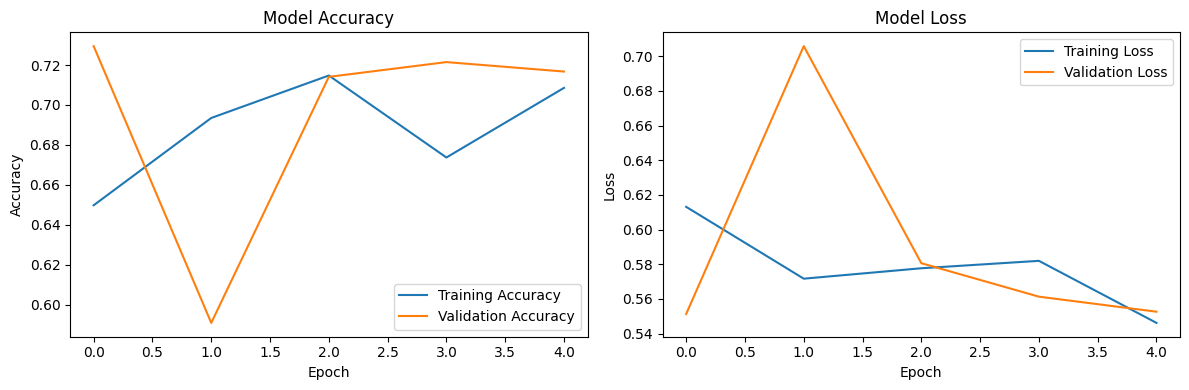

In [138]:
# Assuming you have trained your model and have a `history` object
# after fitting the model

import matplotlib.pyplot as plt

def plots(history):
  # Plot accuracy and loss graphs
  plt.figure(figsize=(12, 4))

  # Plot accuracy
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plot loss
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

plots(history_1)

In [139]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# Assuming you have `y_val_labels` and `y_pred_labels` as the true and predicted labels

# Compute F1 score, precision, and recall
f1_1 = f1_score(y_val_labels_1, y_pred_labels_1, average='weighted')
precision_1 = precision_score(y_val_labels_1, y_pred_labels_1, average='weighted')
recall_1 = recall_score(y_val_labels_1, y_pred_labels_1, average='weighted')

print(f'F1 Score: {f1_1}')
print(f'Precision: {precision_1}')
print(f'Recall: {recall_1}')
print(report_1)

F1 Score: 0.7146613535777488
Precision: 0.7161801677183276
Recall: 0.7167305989967542
{'Hate': {'precision': 0.7212061295106278, 'recall': 0.786522911051213, 'f1-score': 0.7524497163486333, 'support': 1855.0}, 'Not Hate': {'precision': 0.7101024890190337, 'recall': 0.6323337679269883, 'f1-score': 0.6689655172413793, 'support': 1534.0}, 'accuracy': 0.7167305989967542, 'macro avg': {'precision': 0.7156543092648308, 'recall': 0.7094283394891006, 'f1-score': 0.7107076167950064, 'support': 3389.0}, 'weighted avg': {'precision': 0.7161801677183276, 'recall': 0.7167305989967542, 'f1-score': 0.7146613535777488, 'support': 3389.0}}


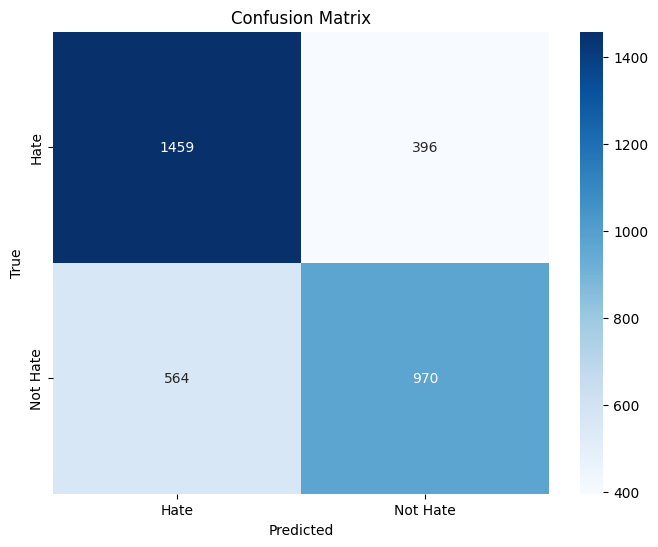

In [140]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true labels (y_true) and predicted labels (y_pred)
# y_true = true_labels
# y_pred = predicted_labels

# Generate the confusion matrix
conf_matrix_1 = confusion_matrix(y_val_labels_1, y_pred_labels_1)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hate','Not Hate'],
            yticklabels=['Hate','Not Hate'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [141]:
average_precision_2, average_recall_2, average_f1_score_2, history_2, model_2, report_2, y_val_labels_2, y_pred_labels_2=fn(X2,y2)
# Display the average classification report
average_report_2 = f'Average Precision: {average_precision_2:.2f}\nAverage Recall: {average_recall_2:.2f}\nAverage F1-Score: {average_f1_score_2:.2f}'
print(f'Average Classification Report Across {n_splits} Folds:\n{average_report_2}')

Epoch 1/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 72s 567ms/step - accuracy: 0.6942 - loss: 0.5847 - val_accuracy: 0.7976 - val_loss: 0.4289
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 65s 455ms/step - accuracy: 0.8073 - loss: 0.4346 - val_accuracy: 0.8442 - val_loss: 0.3999
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 84s 479ms/step - accuracy: 0.8345 - loss: 0.3936 - val_accuracy: 0.8487 - val_loss: 0.3826
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 82s 476ms/step - accuracy: 0.8433 - loss: 0.3744 - val_accuracy: 0.8339 - val_loss: 0.3988
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 54s 513ms/step - accuracy: 0.8511 - loss: 0.3636 - val_accuracy: 0.8484 - val_loss: 0.3713
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step
Fold 1 - Classification Report:
              precision    recall  f1-score   support

        Hate       0.81      0.76      0.78      1218
    Not Hate       0.87      0.90      0.88      2172

    accuracy                           0.85      3390
   macro avg       0.84      0.83      0.83      3390
weig

In [142]:
model_2.save('/content/drive/MyDrive/NLP_Project/NLP/CNN_BiLSTM_ICON_l2_Tamil_Binary_Classification.h5')

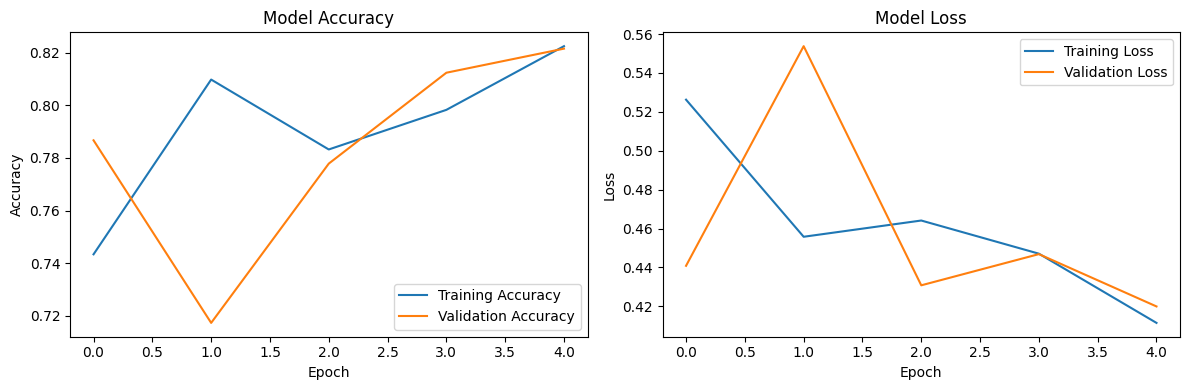

In [143]:
plots(history_2)

In [144]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# Assuming you have `y_val_labels` and `y_pred_labels` as the true and predicted labels

# Compute F1 score, precision, and recall
f1_2 = f1_score(y_val_labels_2, y_pred_labels_2, average='weighted')
precision_2 = precision_score(y_val_labels_2, y_pred_labels_2, average='weighted')
recall_2 = recall_score(y_val_labels_2, y_pred_labels_2, average='weighted')

print(f'F1 Score: {f1_2}')
print(f'Precision: {precision_2}')
print(f'Recall: {recall_2}')
print(report_2)

F1 Score: 0.8223239596535455
Precision: 0.8234708161496836
Recall: 0.8214812629094128
{'Hate': {'precision': 0.7236394557823129, 'recall': 0.7524314765694076, 'f1-score': 0.7377546597312528, 'support': 1131.0}, 'Not Hate': {'precision': 0.8734749209218255, 'recall': 0.8560673162090345, 'f1-score': 0.8646835159919481, 'support': 2258.0}, 'accuracy': 0.8214812629094128, 'macro avg': {'precision': 0.7985571883520692, 'recall': 0.804249396389221, 'f1-score': 0.8012190878616005, 'support': 3389.0}, 'weighted avg': {'precision': 0.8234708161496836, 'recall': 0.8214812629094128, 'f1-score': 0.8223239596535455, 'support': 3389.0}}


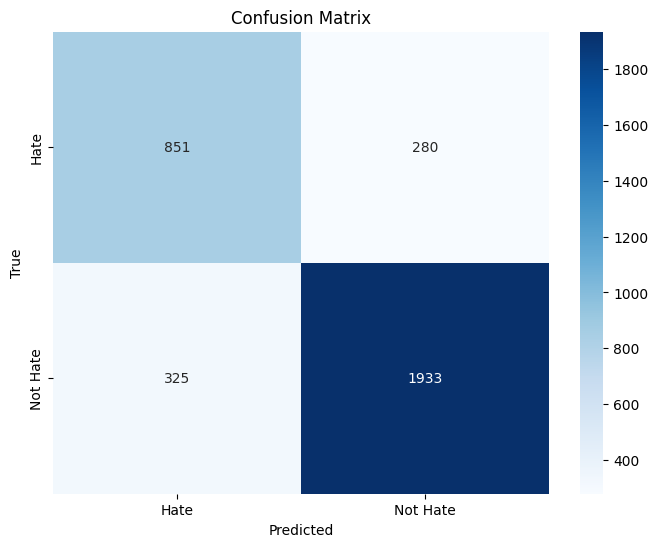

In [145]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true labels (y_true) and predicted labels (y_pred)
# y_true = true_labels
# y_pred = predicted_labels

# Generate the confusion matrix
conf_matrix_2 = confusion_matrix(y_val_labels_2, y_pred_labels_2)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hate','Not Hate'],
            yticklabels=['Hate','Not Hate'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [146]:
average_precision_3, average_recall_3, average_f1_score_3, history_3, model_3, report_3, y_val_labels_3, y_pred_labels_3=fn(X3,y3)
# Display the average classification report
average_report_3 = f'Average Precision: {average_precision_3:.3f}\nAverage Recall: {average_recall_3:.3f}\nAverage F1-Score: {average_f1_score_3:.3f}'
print(f'Average Classification Report Across {n_splits} Folds:\n{average_report_3}')

Epoch 1/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 72s 573ms/step - accuracy: 0.6784 - loss: 0.6026 - val_accuracy: 0.7761 - val_loss: 0.4754
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 72s 536ms/step - accuracy: 0.7910 - loss: 0.4737 - val_accuracy: 0.8360 - val_loss: 0.4043
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 81s 522ms/step - accuracy: 0.8242 - loss: 0.4293 - val_accuracy: 0.8027 - val_loss: 0.4147
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 78s 486ms/step - accuracy: 0.8312 - loss: 0.3884 - val_accuracy: 0.8192 - val_loss: 0.4128
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 86s 520ms/step - accuracy: 0.8080 - loss: 0.4312 - val_accuracy: 0.8348 - val_loss: 0.3990
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step
Fold 1 - Classification Report:
              precision    recall  f1-score   support

        Hate       0.75      0.80      0.78      1218
    Not Hate       0.88      0.85      0.87      2172

    accuracy                           0.83      3390
   macro avg       0.82      0.83      0.82      3390
wei

In [147]:
model_3.save('/content/drive/MyDrive/NLP_Project/NLP/CNN_BiLSTM_ICON_l3_Tamil_Binary_Classification.h5')

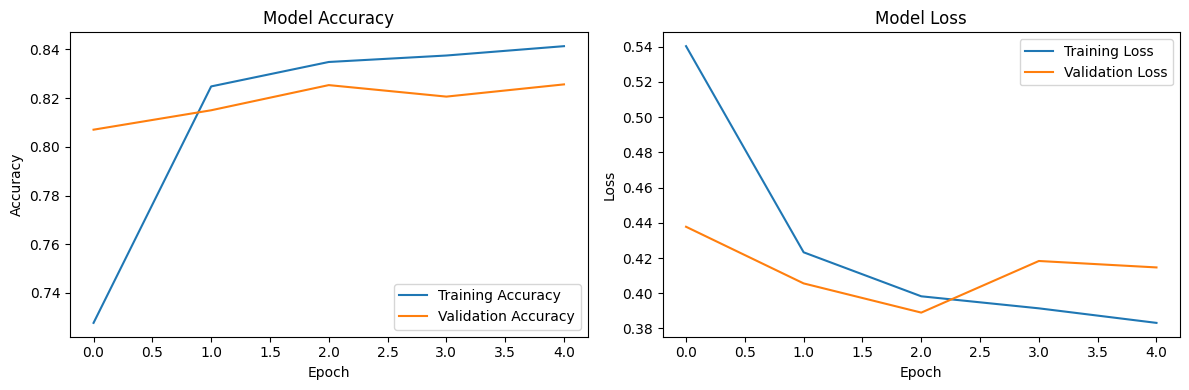

In [148]:
plots(history_3)

In [149]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# Assuming you have `y_val_labels` and `y_pred_labels` as the true and predicted labels

# Compute F1 score, precision, and recall
f1_3 = f1_score(y_val_labels_3, y_pred_labels_3, average='weighted')
precision_3 = precision_score(y_val_labels_3, y_pred_labels_3, average='weighted')
recall_3 = recall_score(y_val_labels_3, y_pred_labels_3, average='weighted')

print(f'F1 Score: {f1_3}')
print(f'Precision: {precision_3}')
print(f'Recall: {recall_3}')
print(report_3)

F1 Score: 0.826873090901119
Precision: 0.8288907625356616
Recall: 0.8256122750073768
{'Hate': {'precision': 0.7246256239600666, 'recall': 0.7701149425287356, 'f1-score': 0.7466780968709815, 'support': 1131.0}, 'Not Hate': {'precision': 0.8811156835848194, 'recall': 0.8534100974313552, 'f1-score': 0.8670416197975254, 'support': 2258.0}, 'accuracy': 0.8256122750073768, 'macro avg': {'precision': 0.802870653772443, 'recall': 0.8117625199800453, 'f1-score': 0.8068598583342534, 'support': 3389.0}, 'weighted avg': {'precision': 0.8288907625356616, 'recall': 0.8256122750073768, 'f1-score': 0.826873090901119, 'support': 3389.0}}


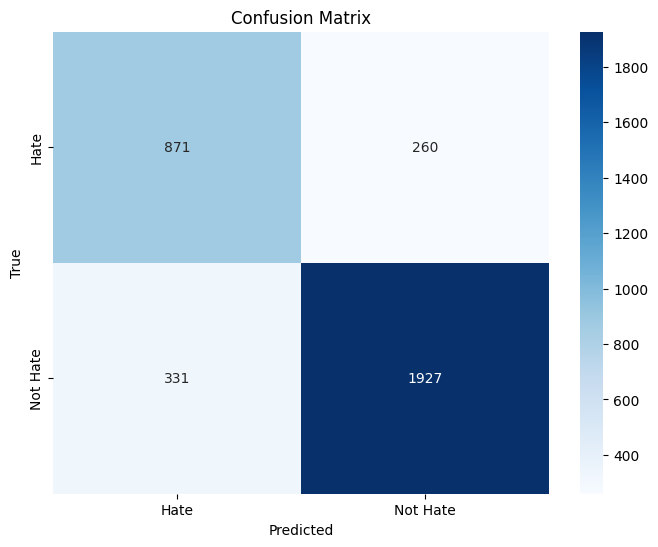

In [150]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true labels (y_true) and predicted labels (y_pred)
# y_true = true_labels
# y_pred = predicted_labels

# Generate the confusion matrix
conf_matrix_3 = confusion_matrix(y_val_labels_3, y_pred_labels_3)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_3, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hate','Not Hate'],
            yticklabels=['Hate','Not Hate'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Testing on Unseen Data

In [174]:
# vv= pd.read_csv('/content/test_label1.csv')
vv_1= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/testing/test_ta_l1.csv')
vv_2= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/testing/test_ta_l2.csv')
vv_3= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/testing/test_ta_l3.csv')


In [175]:
# # vv = vv[vv['language'] == 'tamil']
vv1=vv_1
vv2=vv_2
vv3=vv_3

In [176]:
from tensorflow import keras

model1 = keras.models.load_model('/content/drive/MyDrive/NLP_Project/NLP/CNN_BiLSTM_ICON_l1_Tamil_Binary_Classification.h5')
model2 = keras.models.load_model('/content/drive/MyDrive/NLP_Project/NLP/CNN_BiLSTM_ICON_l2_Tamil_Binary_Classification.h5')
model3 = keras.models.load_model('/content/drive/MyDrive/NLP_Project/NLP/CNN_BiLSTM_ICON_l3_Tamil_Binary_Classification.h5')

In [177]:
vv_1['text'] = vv_1['text'].apply(lambda x: normalize_text(x))
vv_2['text'] = vv_2['text'].apply(lambda x: normalize_text(x))
vv_3['text'] = vv_3['text'].apply(lambda x: normalize_text(x))
# vv['text'] = vv['text'].apply(lambda x: normalize_text_2(x))
vv_1 = vv_1[['text']]
vv_2 = vv_2[['text']]
vv_3 = vv_3[['text']]
vv_1.columns = ['text']
vv_2.columns = ['text']
vv_3.columns = ['text']
vv_1

,text
0,வைரமுத்து ஒரு காம மிருகம் என்பது சினிமா துற...
1,valimai ajithkumar ஏண்டா குள்ள புண்டைக...
2,ambedkarblueshirtrally இந்த போராட்டத்துக்கு ...
3,breaking திருச்சி மாவட்டம் மணப்பாறையை அடுத...
4,bachelor படமாடா இது கோத்தா
...,...
1130,ஊம்பு
1131,தமிழ் தெரிஞ்சவன் தான் உங்கொம்மால குண்டி அடிக்...
1132,நீ தான் பங் அவனோலுக்கு கரெக்டா ஆன ஆளு லத்த...
1133,— ஆமாம் வேச ஆமாம் வேச அய்ம் ச்லீபின் அய்ம் ச்...


In [154]:
# ## Word Pre-Processing ##
# import nltk
# import string
# import re

# ## Function to normalize text for pre-processing ##
# def normalize_text(text):
#   emoji_pattern = re.compile("["
#                               u"\U0001F600-\U0001F64F"  # emoticons
#                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                               u"\U0001F700-\U0001F77F"  # alchemical symbols
#                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
#                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
#                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
#                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
#                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
#                               u"\U00002702-\U000027B0"  # Dingbats
#                               u"\U000024C2-\U0001F251"
#                               "]+", flags=re.UNICODE)
#   text = text.lower()
#   text = re.sub('\[.*?\]', ' ', text)
#   text = re.sub('https?://\S+|www\.\S+', ' ', text)
#   text = re.sub('<.*?>+', ' ', text)
#   text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
#   text = re.sub('\n', ' ', text)
#   text = re.sub('\w*\d\w*', ' ', text)
#   text = re.sub('<handle replaced>', '', text)
#   text = emoji_pattern.sub(r'', text)
#   return text
# ## Apply the written function ##
# vv1['text'] = vv1['text'].apply(lambda x: normalize_text(x))
# vv1
# vv2['text'] = vv2['text'].apply(lambda x: normalize_text(x))
# vv2
# vv3['text'] = vv3['text'].apply(lambda x: normalize_text(x))
# vv3

,text,key,ta_a1,ta_a2,ta_a3,ta_a4,ta_a5,ta_a6
0,வைரமுத்து ஒரு காம மிருகம் என்பது சினிமா துற...,question_3,NaN,NaN,0.0,0.0,NaN,0.0
1,valimai ajithkumar ஏண்டா குள்ள புண்டைக...,question_3,1.0,NaN,1.0,1.0,NaN,NaN
2,ambedkarblueshirtrally இந்த போராட்டத்துக்கு ...,question_3,1.0,1.0,0.0,NaN,NaN,NaN
3,breaking திருச்சி மாவட்டம் மணப்பாறையை அடுத...,question_3,0.0,NaN,0.0,0.0,0.0,0.0
4,bachelor படமாடா இது கோத்தா,question_3,1.0,1.0,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...
1130,ஊம்பு,question_3,1.0,1.0,NaN,1.0,NaN,NaN
1131,தமிழ் தெரிஞ்சவன் தான் உங்கொம்மால குண்டி அடிக்...,question_3,1.0,1.0,NaN,NaN,1.0,NaN
1132,நீ தான் பங் அவனோலுக்கு கரெக்டா ஆன ஆளு லத்த...,question_3,NaN,NaN,1.0,0.0,NaN,1.0
1133,— ஆமாம் வேச ஆமாம் வேச அய்ம் ச்லீபின் அய்ம் ச்...,question_3,NaN,0.0,NaN,1.0,1.0,NaN


In [178]:
######## Textual Features for Embedding ###################

sequence1 = tokenizer.texts_to_sequences(vv1.text)
sequence1 = pad_sequences(sequence1, padding='post', maxlen=max_seq_length)

sequence2 = tokenizer.texts_to_sequences(vv2.text)
sequence2 = pad_sequences(sequence2, padding='post', maxlen=max_seq_length)

sequence3 = tokenizer.texts_to_sequences(vv3.text)
sequence3 = pad_sequences(sequence3, padding='post', maxlen=max_seq_length)

In [179]:
sequence1 = tokenizer.texts_to_sequences(vv1['text']) # same tokenizer which is used on train data.
sequence1 = pad_sequences(sequence1,padding='post', maxlen = max_seq_length)

sequence2 = tokenizer.texts_to_sequences(vv2['text']) # same tokenizer which is used on train data.
sequence2 = pad_sequences(sequence2,padding='post', maxlen = max_seq_length)

sequence3 = tokenizer.texts_to_sequences(vv3['text']) # same tokenizer which is used on train data.
sequence3 = pad_sequences(sequence3,padding='post', maxlen = max_seq_length)

predictions1 = model_1.predict(sequence1)
classes1=np.argmax(predictions1,axis=1)

predictions2 = model_2.predict(sequence2)
classes2=np.argmax(predictions2,axis=1)

predictions3 = model_3.predict(sequence3)
classes3=np.argmax(predictions3,axis=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step


In [180]:
predictions1



array([[0.51095086, 0.4890492 ],
       [0.478835  , 0.521165  ],
       [0.8982068 , 0.10179324],
       ...,
       [0.3562157 , 0.64378434],
       [0.83655727, 0.16344276],
       [0.5295004 , 0.47049958]], dtype=float32)

In [181]:
predictions2



array([[0.13956943, 0.8604306 ],
       [0.13110597, 0.86889404],
       [0.7750886 , 0.22491139],
       ...,
       [0.09011812, 0.9098819 ],
       [0.7337922 , 0.2662078 ],
       [0.41893867, 0.5810613 ]], dtype=float32)

In [182]:
predictions3

array([[0.07094125, 0.92905873],
       [0.07261751, 0.9273825 ],
       [0.8701187 , 0.12988134],
       ...,
       [0.060868  , 0.93913203],
       [0.87431425, 0.12568578],
       [0.16100751, 0.83899254]], dtype=float32)

In [183]:
pred1 = np.argmax(predictions1, axis=1)
pred2 = np.argmax(predictions2, axis=1)
pred3 = np.argmax(predictions3, axis=1)

pred1



array([0, 1, 0, ..., 1, 0, 0])

In [184]:
pred2


array([1, 1, 0, ..., 1, 0, 1])

In [185]:
pred3

array([1, 1, 0, ..., 1, 0, 1])

In [186]:
col_lst = ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']
for col in col_lst:
    vv1[col] = pd.to_numeric(vv1[col], errors='coerce')
    vv2[col] = pd.to_numeric(vv2[col], errors='coerce')
    vv3[col] = pd.to_numeric(vv3[col], errors='coerce')


vv1['label'] = vv1[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values
vv2['label'] = vv2[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values
vv3['label'] = vv3[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values

vv1['label'] = vv1['label'].astype(int)
vv2['label'] = vv2['label'].astype(int)
vv3['label'] = vv3['label'].astype(int)

vv1 = vv1[['label', 'text']]
vv2 = vv2[['label', 'text']]
vv3 = vv3[['label', 'text']]
vv1

true_1 = vv1["label"]
true_2 = vv2["label"]
true_3 = vv3["label"]
# print(true_)
y_test_1 = true_1.values
y_test_2 = true_2.values
y_test_3 = true_3.values
print(y_test_1)
print(len(y_test_1))

[0 1 0 ... 1 1 1]
1135


In [188]:
# Extract the predicted class labels
predictions1 = np.argmax(predictions1, axis=1)
predictions2 = np.argmax(predictions2, axis=1)
predictions3 = np.argmax(predictions3, axis=1)


In [189]:
ids = np.arange(1, len(y_test_1)+1)
result_df_1 = pd.DataFrame({'id': ids, 'prediction': predictions1, 'true': y_test_1})
# result_df_1

ids = np.arange(1, len(y_test_2)+1)
result_df_2 = pd.DataFrame({'id': ids, 'prediction': predictions2, 'true': y_test_2})
# result_df_2

ids = np.arange(1, len(y_test_3)+1)
result_df_3 = pd.DataFrame({'id': ids, 'prediction': predictions3, 'true': y_test_3})
result_df_3

,id,prediction,true
0,1,1,0
1,2,1,1
2,3,0,1
3,4,0,0
4,5,1,1
...,...,...,...
1130,1131,1,1
1131,1132,1,1
1132,1133,1,1
1133,1134,0,1


In [198]:
# Save the DataFrame to a CSV file
# result_df.to_csv('/content/Tamil_Task3_output.csv', index=False)
result_df_1.to_csv('/content/drive/MyDrive/NLP_Project/NLP/output_Tamil_l1.csv', index=False)
result_df_2.to_csv('/content/drive/MyDrive/NLP_Project/NLP/output_Tamil_l2.csv', index=False)
result_df_3.to_csv('/content/drive/MyDrive/NLP_Project/NLP/output_Tamil_l3.csv', index=False)

Similarly, the output for test_label3.csv is found by simply changing the path.


In [194]:
def compute_metrics(result_df, color):
    # Compute metrics
    accuracy = accuracy_score(result_df['true'], result_df['prediction'])
    f1 = f1_score(result_df['true'], result_df['prediction'], average='weighted')  # Use 'macro', 'micro', or 'weighted' as needed
    recall = recall_score(result_df['true'], result_df['prediction'], average='weighted')
    precision = precision_score(result_df['true'], result_df['prediction'], average='weighted')
    conf_matrix = confusion_matrix(result_df['true'], result_df['prediction'])

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    # print("Confusion Matrix:")
    # print(conf_matrix)

    conf_matrix = confusion_matrix(result_df['true'], result_df['prediction'])

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=color, xticklabels=set(result_df['true']), yticklabels=set(result_df['true']))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


Accuracy: 0.7207
F1 Score: 0.7238
Recall: 0.7207
Precision: 0.7996


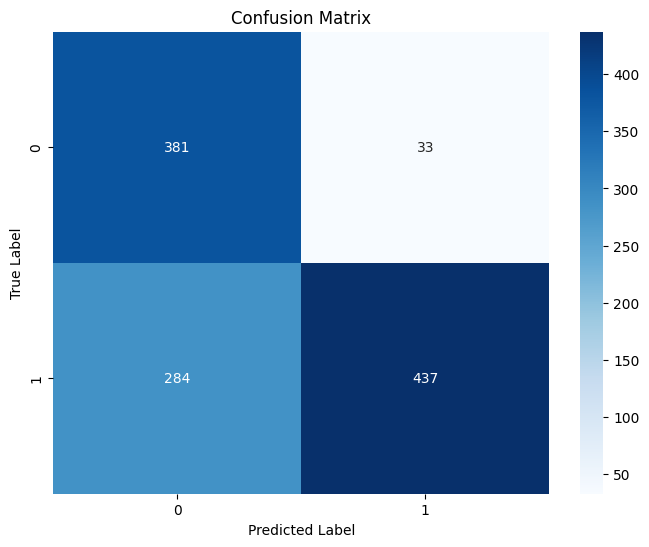

In [195]:
compute_metrics(result_df_1, "Blues")

Accuracy: 0.7956
F1 Score: 0.8053
Recall: 0.7956
Precision: 0.8280


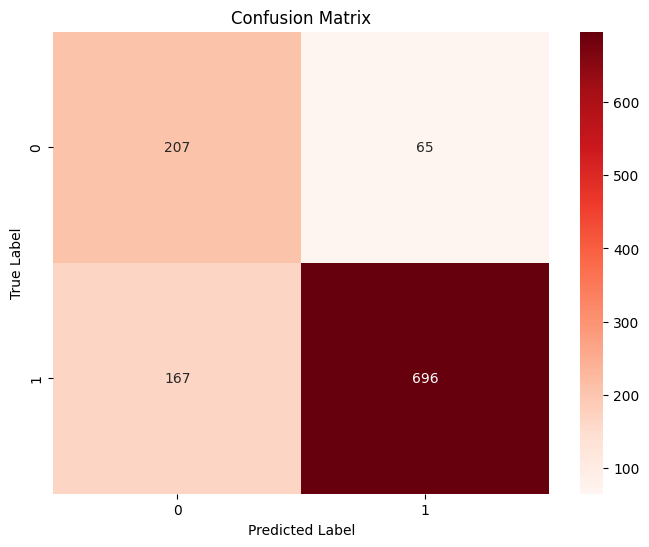

In [196]:
compute_metrics(result_df_2, "Reds")

Accuracy: 0.8485
F1 Score: 0.8565
Recall: 0.8485
Precision: 0.8872


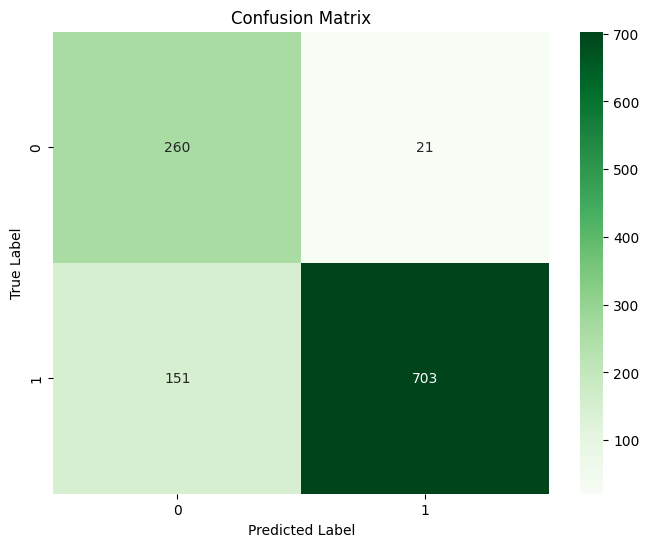

In [197]:
compute_metrics(result_df_3, "Greens")